## <a>Introduction</a>

This NLP project is to examine the following
* The best classifier that will give the best metric in terms of accuracy and classification matrix
* The best approach that explain/interpret the result/performance  of the model

In [1]:
#-----Import  packages

import io
import os
import re
import json
import multiprocessing
import time
import nltk
import sklearn
#nltk.download()
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import collections
import sklearn.ensemble
import random

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor,AdaBoostClassifier
from sklearn.ensemble import ExtraTreesRegressor,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.svm import SVR,SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import tree, ensemble, linear_model
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


import sklearn.metrics
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import warnings

warnings.filterwarnings("ignore")


### Load the data  and EDA

In [2]:
path = r"C:\Users\oadejo\Desktop\R&M_2016.csv"
df= pd.read_csv(path)

In [3]:
print(df.head())
print(df.shape)

  IE Pairs                          NARRARIVE 1              NARRATIVE 3  \
0  OPF RPM  WEB TERMINAL FEE FOR JAN - MARCH 16         INV NO 700019074   
1  OPF RPM    WEB TERMINAL FEE FOR APR - JUN 16         INV NO 700023983   
2  OPF RPM  WEB TERMINAL FEE FOR JULY - SEPT 16         INV NO 700030270   
3  OPF RPM         WEB TERMINAL FEE OCT-DEC2016         INV NO 700035375   
4   OP RPM          AIR-COND DUCTING WORKS @ F6  MY0020006537 I16062951I   

          NARRATIVE 4  AMOUNT    Category  
0                 NaN -2400.0  Deductible  
1                 NaN -2400.0  Deductible  
2                 NaN -2400.0  Deductible  
3                 NaN -2400.0  Deductible  
4  APPRAISAL PROPERTY -1620.0     Capital  
(4850, 6)


In [4]:
# Number in each category
df['Category'].value_counts()
#collections.Counter(y)

Deductible        4456
Capital            297
Provision           61
Non-deductible      36
Name: Category, dtype: int64

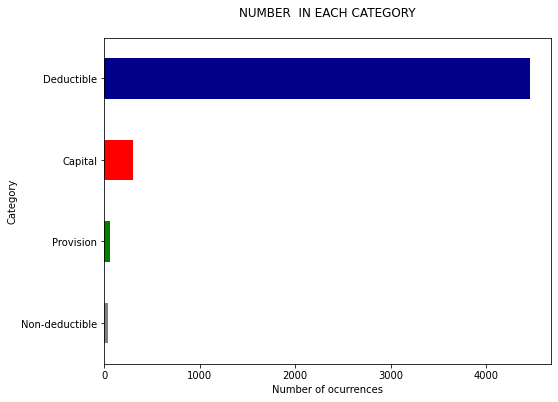

In [5]:
## Visualize the number ine each category
## Check the class inbalance
fig = plt.figure(figsize=(8,6))
colors = ['grey','green','red','darkblue']
df.groupby('Category').Category.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER  IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

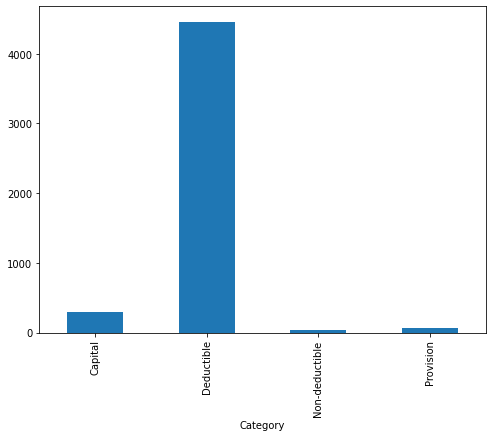

In [6]:
## Check the class inbalance 2
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Category.count().plot.bar(ylim=0)
plt.show()

In [7]:
## Checking the sum of na in each column
df.isnull().sum()

IE Pairs         0
NARRARIVE 1      5
NARRATIVE 3      4
NARRATIVE 4    277
AMOUNT           0
Category         0
dtype: int64

In [8]:
## Fill na in the dataframe  with blank
df.fillna('', inplace =True)  # Replancing na  with blank


In [9]:
# Binning categorisation of the the AMOUNT volumn
df['amt_bin']=pd.cut(x=df['AMOUNT'],
                     bins=[-1680000,-10000, 0, 10000, 1680000 ],
                     labels=['high negative','low negative','low positive','high positive'])

In [10]:
df.head()

,IE Pairs,NARRARIVE 1,NARRATIVE 3,NARRATIVE 4,AMOUNT,Category,amt_bin
0,OPF RPM,WEB TERMINAL FEE FOR JAN - MARCH 16,INV NO 700019074,,-2400.0,Deductible,low negative
1,OPF RPM,WEB TERMINAL FEE FOR APR - JUN 16,INV NO 700023983,,-2400.0,Deductible,low negative
2,OPF RPM,WEB TERMINAL FEE FOR JULY - SEPT 16,INV NO 700030270,,-2400.0,Deductible,low negative
3,OPF RPM,WEB TERMINAL FEE OCT-DEC2016,INV NO 700035375,,-2400.0,Deductible,low negative
4,OP RPM,AIR-COND DUCTING WORKS @ F6,MY0020006537 I16062951I,APPRAISAL PROPERTY,-1620.0,Capital,low negative


In [11]:
##Concatenate the columns into a single one

df['Description']=df[["NARRARIVE 1","NARRATIVE 4",'amt_bin']].agg(' '.join, axis=1)

In [12]:
# selecting columns for further analysis
df1=df[['IE Pairs','Description','Category']]
df1.head()

,IE Pairs,Description,Category
0,OPF RPM,WEB TERMINAL FEE FOR JAN - MARCH 16 low negative,Deductible
1,OPF RPM,WEB TERMINAL FEE FOR APR - JUN 16 low negative,Deductible
2,OPF RPM,WEB TERMINAL FEE FOR JULY - SEPT 16 low negative,Deductible
3,OPF RPM,WEB TERMINAL FEE OCT-DEC2016 low negative,Deductible
4,OP RPM,AIR-COND DUCTING WORKS @ F6 APPRAISAL PROPERTY...,Capital


In [13]:
## create a new encoded column
col = [ 'Description','Category']
df1 = df[col]
df1 = df1[pd.notnull(df1['Description'])]
df1.columns = ['Description','Category']
df1['category_id'] = df1['Category'].factorize()[0]
category_id_df = df1[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df1.head()

,Description,Category,category_id
0,WEB TERMINAL FEE FOR JAN - MARCH 16 low negative,Deductible,0
1,WEB TERMINAL FEE FOR APR - JUN 16 low negative,Deductible,0
2,WEB TERMINAL FEE FOR JULY - SEPT 16 low negative,Deductible,0
3,WEB TERMINAL FEE OCT-DEC2016 low negative,Deductible,0
4,AIR-COND DUCTING WORKS @ F6 APPRAISAL PROPERTY...,Capital,1


In [14]:
# Rechecking the numbers of null
df1.isnull().sum()

Description    0
Category       0
category_id    0
dtype: int64

## Text Pre-processing
* Clean the data
* Remove punctuation
* Tokenization
* Remove stopword
* Vectorizer

# Single function to do cleaning, tokenize and remove stopwords


In [15]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

In [16]:

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


df1['text_clean']=df1['Description'].map(lambda s:preprocess(s)) 

In [17]:
df1.head()

,Description,Category,category_id,text_clean
0,WEB TERMINAL FEE FOR JAN - MARCH 16 low negative,Deductible,0,web terminal fee jan march low negative
1,WEB TERMINAL FEE FOR APR - JUN 16 low negative,Deductible,0,web terminal fee apr jun low negative
2,WEB TERMINAL FEE FOR JULY - SEPT 16 low negative,Deductible,0,web terminal fee july sept low negative
3,WEB TERMINAL FEE OCT-DEC2016 low negative,Deductible,0,web terminal fee oct dec low negative
4,AIR-COND DUCTING WORKS @ F6 APPRAISAL PROPERTY...,Capital,1,air cond ducting works appraisal property low ...


In [78]:

df1.keys()

Index(['Description', 'Category', 'category_id', 'text_clean'], dtype='object')

In [89]:
data = df1
labels = df1.Category
target_names = ["Deductible","Capital","Provision","Non-deductible"]

In [92]:
train, test, train_labels, test_labels = train_test_split(data, labels, test_size=.2, random_state=42)
train, val, train_labels, val_labels = train_test_split(train, train_labels, test_size=.1, random_state=42)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

In [93]:
vectorizer = CountVectorizer(min_df=1)
vectorizer.fit(train)

CountVectorizer()

In [96]:
np.random.seed(0)
clf = LogisticRegression(solver='liblinear')
clf.fit(vectorizer.transform(train), train_labels)

ValueError: Found input variables with inconsistent numbers of samples: [4, 3492]